In [ ]:
# Import necessary libraries
%pip install --upgrade pydantic
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tika import parser
import spacy
from spacy.matcher import Matcher

In [3]:
#Load and preprocess the dataset
df = pd.read_csv("C:/Users/Admin/Desktop/Resume/Resume.csv")
df['Resume'] = df['Resume_str'].apply(lambda w: re.sub(r'\W+', ' ', w.lower()))

In [4]:
df.head()


,ID,Resume_str,Resume_html,Category,Resume
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administrator marketing associate hr admin...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist us hr operations summary versat...
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr director summary over 20 years experience ...
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist summary dedicated driven and dy...
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr manager skill highlights hr skills hr depa...


In [47]:
columns = df.columns.tolist()
print("Columns in the dataset:")
print(columns)


Columns in the dataset:
['ID', 'Resume_str', 'Resume_html', 'Category', 'Resume']


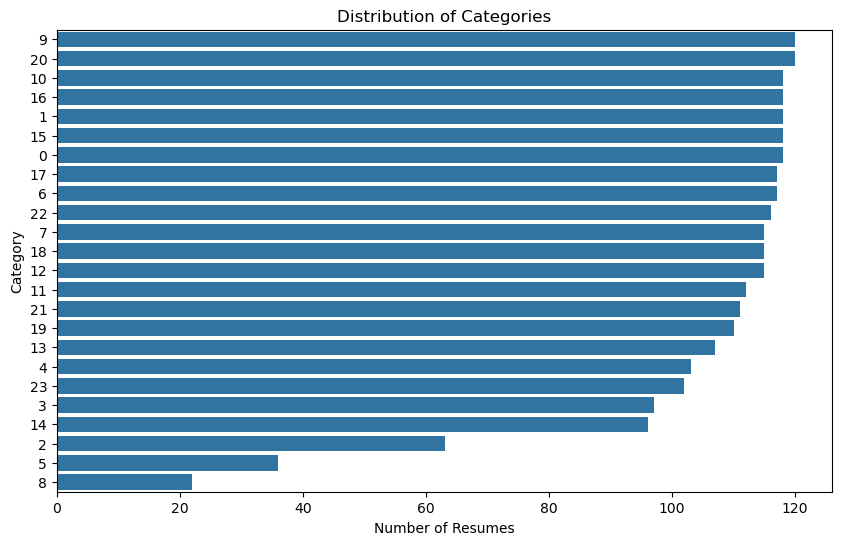

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Number of Resumes')
plt.ylabel('Category')
plt.show()


In [5]:
# Encode labels
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

In [6]:
# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# Extract features and labels
features = df['Resume'].values
labels = df['Category'].values

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)


In [9]:
# Step 2: Tokenize and pad the sequences
vocab_size = 6000
oov_tok = '<OOV>'
max_length = 300

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')


In [10]:

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=len(le.classes_))
y_test = to_categorical(y_test, num_classes=len(le.classes_))

In [11]:
# Step 3: Define and compile the neural network
embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:

# Step 4: Train the model
num_epochs = 10
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test), verbose=2)


Epoch 1/10
63/63 - 13s - 214ms/step - accuracy: 0.2164 - loss: 3.1055 - val_accuracy: 0.4306 - val_loss: 2.9166
Epoch 2/10
63/63 - 7s - 117ms/step - accuracy: 0.4504 - loss: 2.3033 - val_accuracy: 0.5915 - val_loss: 1.6990
Epoch 3/10
63/63 - 9s - 141ms/step - accuracy: 0.6799 - loss: 1.2771 - val_accuracy: 0.6620 - val_loss: 1.3442
Epoch 4/10
63/63 - 9s - 142ms/step - accuracy: 0.7816 - loss: 0.8624 - val_accuracy: 0.7123 - val_loss: 1.2498
Epoch 5/10
63/63 - 9s - 144ms/step - accuracy: 0.8541 - loss: 0.5995 - val_accuracy: 0.7203 - val_loss: 1.2800
Epoch 6/10
63/63 - 9s - 149ms/step - accuracy: 0.9029 - loss: 0.3948 - val_accuracy: 0.6861 - val_loss: 1.5148
Epoch 7/10
63/63 - 9s - 146ms/step - accuracy: 0.9346 - loss: 0.2745 - val_accuracy: 0.6901 - val_loss: 1.5692
Epoch 8/10
63/63 - 10s - 157ms/step - accuracy: 0.9658 - loss: 0.1676 - val_accuracy: 0.7062 - val_loss: 1.7073
Epoch 9/10
63/63 - 10s - 154ms/step - accuracy: 0.9869 - loss: 0.0894 - val_accuracy: 0.6801 - val_loss: 1.948

In [13]:
# Step 5: Evaluate the model
score = model.evaluate(X_test_padded, y_test, verbose=1)
print("Test Accuracy:", score[1])


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7006 - loss: 1.8738
Test Accuracy: 0.6941649913787842


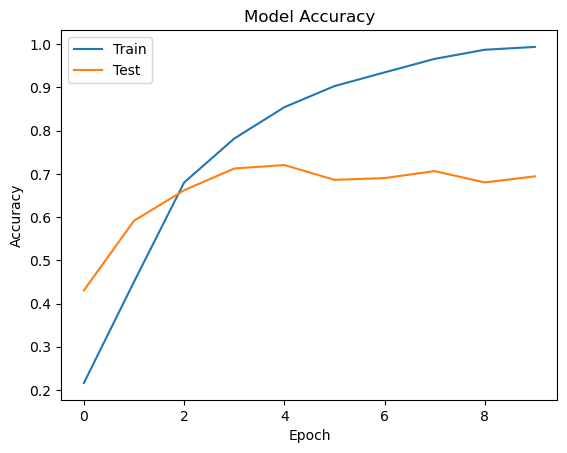

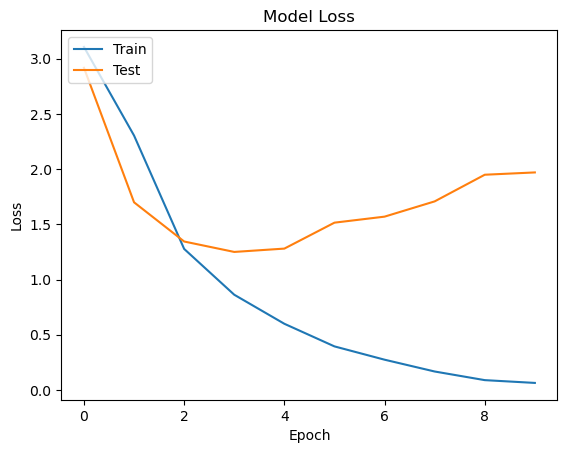

In [14]:
# Plot accuracy and loss graphs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Confusion Matrix:
 [[24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0]
 [ 0  0  0  0  1  1  1  5  0  0  1  0  0  0  0  0  0  0  2  0  1  0  1  0]
 [ 0  0  0  9  1  0  1  0  0  1  1  0  0  0  2  0  0  1  0  0  2  0  1  0]
 [ 0  0  1  0  5  1  2  2  0  0  0  0  0  0  1  0  0  2  1  0  1  4  0  1]
 [ 0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  1  0  0]
 [ 0  0  1  1  3  3 10  1  1  0  0  0  0  0  1  1  0  1  0  0  1  0  0  0]
 [ 0  0  1  1  0  1  0 12  0  0  0  0  0  0  0  0  1  2  1  1  1  2  0  0]
 [ 0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  2  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0 18  0  0  0  0  0  0  1  0  2  1  0  0  1]
 [ 0  0  0  1  1  2  0  1  0  0  0 11  0  1  0  1  0  1  2  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  2 19 

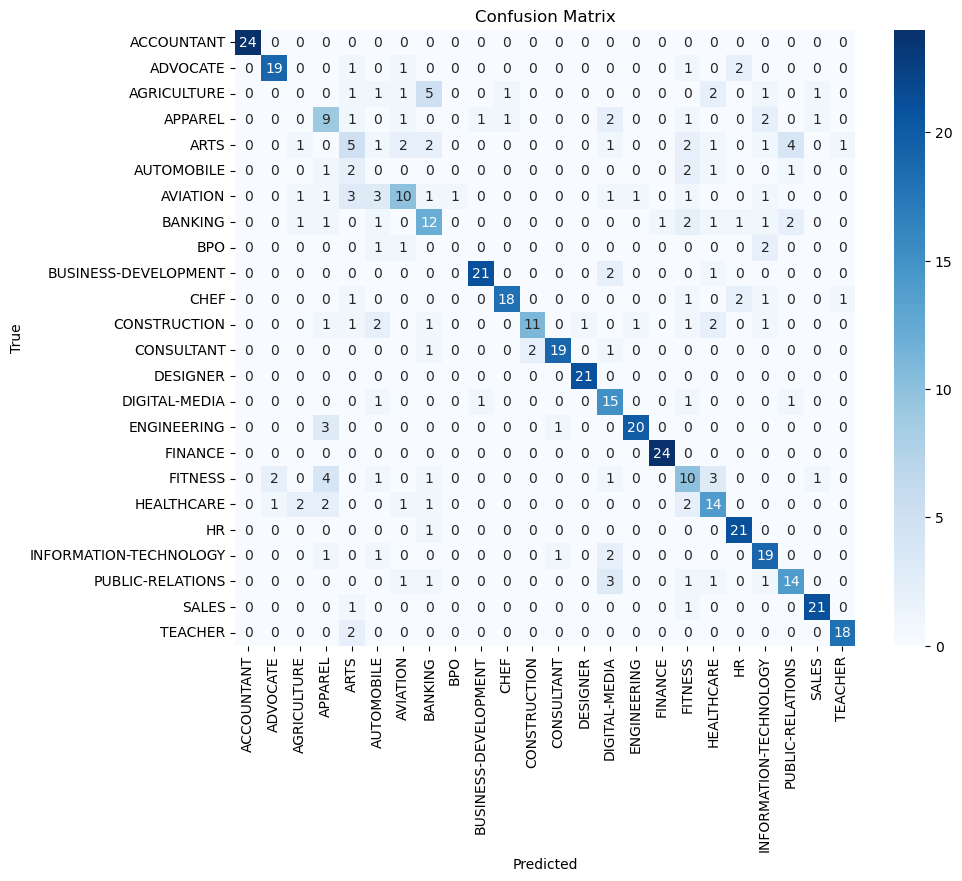

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       1.00      1.00      1.00        24
              ADVOCATE       0.86      0.79      0.83        24
           AGRICULTURE       0.00      0.00      0.00        13
               APPAREL       0.39      0.47      0.43        19
                  ARTS       0.28      0.24      0.26        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.56      0.42      0.48        24
               BANKING       0.46      0.52      0.49        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.91      0.88      0.89        24
                  CHEF       0.90      0.75      0.82        24
          CONSTRUCTION       0.85      0.50      0.63        22
            CONSULTANT       0.90      0.83      0.86        23
              DESIGNER       0.95      1.00      0.98        21
         DIGITA

In [15]:
# Step 6: Generate confusion matrix and classification report
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=le.classes_))


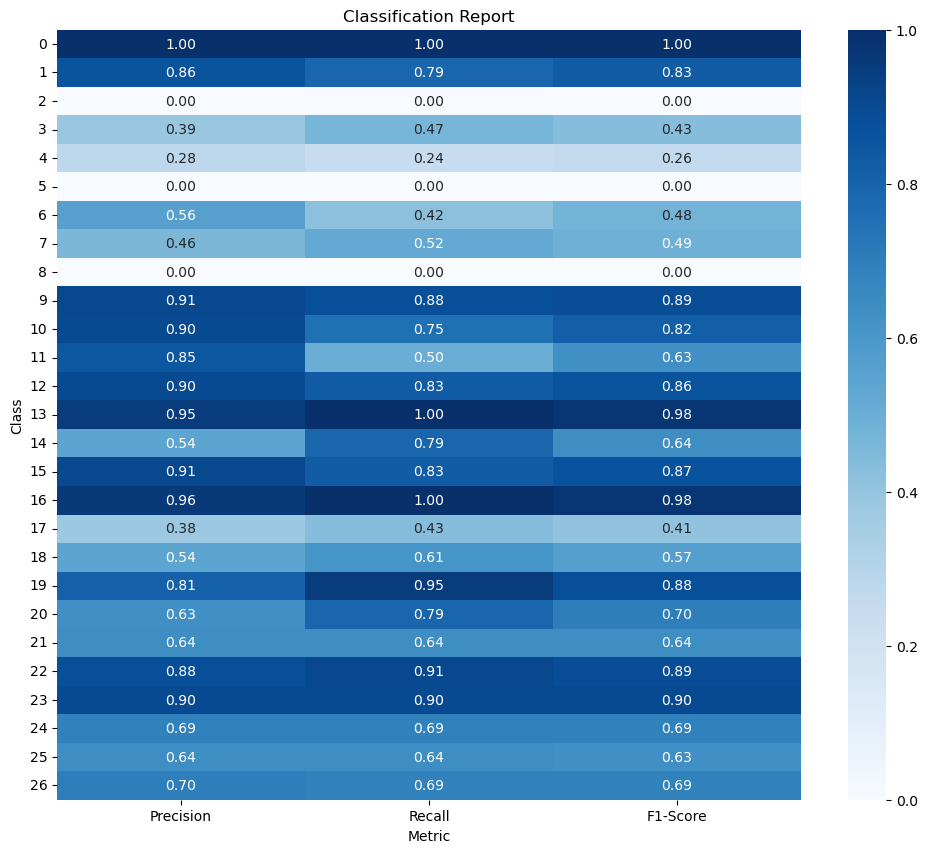

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Sample data
report_dict = {
    "ACCOUNTANT": {"precision": 1.00, "recall": 1.00, "f1-score": 1.00, "support": 24},
    "ADVOCATE": {"precision": 0.86, "recall": 0.79, "f1-score": 0.83, "support": 24},
    "AGRICULTURE": {"precision": 0.00, "recall": 0.00, "f1-score": 0.00, "support": 13},
    "APPAREL": {"precision": 0.39, "recall": 0.47, "f1-score": 0.43, "support": 19},
    "ARTS": {"precision": 0.28, "recall": 0.24, "f1-score": 0.26, "support": 21},
    "AUTOMOBILE": {"precision": 0.00, "recall": 0.00, "f1-score": 0.00, "support": 7},
    "AVIATION": {"precision": 0.56, "recall": 0.42, "f1-score": 0.48, "support": 24},
    "BANKING": {"precision": 0.46, "recall": 0.52, "f1-score": 0.49, "support": 23},
    "BPO": {"precision": 0.00, "recall": 0.00, "f1-score": 0.00, "support": 4},
    "BUSINESS-DEVELOPMENT": {"precision": 0.91, "recall": 0.88, "f1-score": 0.89, "support": 24},
    "CHEF": {"precision": 0.90, "recall": 0.75, "f1-score": 0.82, "support": 24},
    "CONSTRUCTION": {"precision": 0.85, "recall": 0.50, "f1-score": 0.63, "support": 22},
    "CONSULTANT": {"precision": 0.90, "recall": 0.83, "f1-score": 0.86, "support": 23},
    "DESIGNER": {"precision": 0.95, "recall": 1.00, "f1-score": 0.98, "support": 21},
    "DIGITAL-MEDIA": {"precision": 0.54, "recall": 0.79, "f1-score": 0.64, "support": 19},
    "ENGINEERING": {"precision": 0.91, "recall": 0.83, "f1-score": 0.87, "support": 24},
    "FINANCE": {"precision": 0.96, "recall": 1.00, "f1-score": 0.98, "support": 24},
    "FITNESS": {"precision": 0.38, "recall": 0.43, "f1-score": 0.41, "support": 23},
    "HEALTHCARE": {"precision": 0.54, "recall": 0.61, "f1-score": 0.57, "support": 23},
    "HR": {"precision": 0.81, "recall": 0.95, "f1-score": 0.88, "support": 22},
    "INFORMATION-TECHNOLOGY": {"precision": 0.63, "recall": 0.79, "f1-score": 0.70, "support": 24},
    "PUBLIC-RELATIONS": {"precision": 0.64, "recall": 0.64, "f1-score": 0.64, "support": 22},
    "SALES": {"precision": 0.88, "recall": 0.91, "f1-score": 0.89, "support": 23},
    "TEACHER": {"precision": 0.90, "recall": 0.90, "f1-score": 0.90, "support": 20},
    "accuracy": 0.69,
    "macro avg": {"precision": 0.64, "recall": 0.64, "f1-score": 0.63, "support": 497},
    "weighted avg": {"precision": 0.70, "recall": 0.69, "f1-score": 0.69, "support": 497}
}

# Convert to DataFrame
df = pd.DataFrame(report_dict).T
df = df.rename_axis('Class').reset_index()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(df.iloc[:, 1:4], annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title('Classification Report')
plt.xlabel('Metric')
plt.ylabel('Class')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Precision', 'Recall', 'F1-Score'], rotation=0)
plt.yticks(rotation=0)

# Save the image
plt.savefig('classification_report.png')
plt.show()


In [26]:
from tika import parser

# Specify the URL where Tika server is running
tika.TikaClientOnly = True

# Step 7: Extract content from a PDF file
file = r"C:\Users\Admin\Desktop\data\data\CONSTRUCTION\10100240.pdf"
file_data = parser.from_file(file)
text = file_data['content']

print(text)


































CARPENTER APPRENTICE
Professional Summary

Former construction and carpentry worker committed to high-quality workmanship and safe environments. Over 4 years of hands-on experience
working with remodeling projects in residential and commercial construction. Dedicated work ethic and exceptional attendance record. I am
motivated to learn new trades and skills. Interested in growing career and fostering leadership capabilities. Professional Construction Laborer with
excellent interpersonal skills. Works in timely and efficient manner to see tough jobs through to completion.

Skills
Cabinetry
Material prepping
Construction drawing interpretation
Carpentry techniques
Oral and written communication

Materials handling
New construction and renovation
Drywalling
Safety and compliance

Work History
Carpenter Apprentice , 10/2017 to 09/2019 
Company Name â€“ City , State 

Assisted with movement of materials and equipment to job sites
Worked with master carpenters

In [27]:
# Extract email addresses
def get_email_addresses(string):
    r = re.compile(r'[\w\.-]+@[\w\.-]+')
    return r.findall(string)

email = get_email_addresses(text)
print("Emails:", email)


Emails: []


In [28]:
# Extract phone numbers
def get_phone_numbers(string):
    r = re.compile(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')
    phone_numbers = r.findall(string)
    return [re.sub(r'\D', '', num) for num in phone_numbers]

phone_number = get_phone_numbers(text)
if phone_number:
    print("Phone Numbers:", phone_number)

In [33]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag, ne_chunk
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def extract_name(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    chunked = ne_chunk(tagged)
    for chunk in chunked:
        if isinstance(chunk, nltk.Tree) and chunk.label() == 'PERSON':
            return ' '.join([word for word, pos in chunk.leaves()])

text = "John Doe is a software engineer."
name = extract_name(text)
print("Name:", name)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Name: John


In [34]:
# Step 8: Parse the content based on keywords
Keywords = [
    "education", "summary", "accomplishments", "executive profile", 
    "professional profile", "personal profile", "work background", 
    "academic profile", "other activities", "qualifications", 
    "experience", "interests", "skills", "achievements", 
    "publications", "publication", "certifications", "workshops", 
    "projects", "internships", "trainings", "hobbies", "overview", 
    "objective", "position of responsibility", "jobs"
]

text = text.replace("\n", " ")
text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
text = text.lower()

content = {}
indices = []
keys = []

for key in Keywords:
    try:
        content[key] = text[text.index(key) + len(key):]
        indices.append(text.index(key))
        keys.append(key)
    except ValueError:
        pass

In [39]:
# Sample data for indices and keys (replace with your actual data)
indices = [5, 10, 20]
keys = ['summary', 'experience', 'projects', 'skills', 'jobs', 'objective', 'education', 'certifications', 'awards']

# Sort the indices and corresponding keys
sorted_pairs = sorted(zip(indices, keys))

if sorted_pairs:  # Check if sorted_pairs is not empty
    indices, keys = zip(*sorted_pairs)
else:
    indices, keys = [], []  # Handle the case where sorted_pairs is empty

# Continue with your logic
content = []
for idx in range(len(indices)):
    if idx != len(indices) - 1:
        content.append(text[indices[idx]:indices[idx + 1]])
    else:
        content.append(text[indices[idx]:])


In [44]:
# Store the parsed content in a dictionary
parsed_content = {keys[i]: content[i] for i in range(len(indices))}


In [43]:
# Convert the parsed content to a DataFrame
parsed_content_df = pd.DataFrame(parsed_content.items(), columns=["Section", "Content"])
print(parsed_content_df)

      Section       Content
0     summary         doe i
1  experience    s a softwa
2    projects  re engineer 
